In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from numpy import timedelta64, log as nplog
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
dfacme=pd.read_excel("acme PF-Dec2021-Part-Sent.xlsx")
dfacme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18366 entries, 0 to 18365
Data columns (total 23 columns):
 #   Column                                                   Non-Null Count  Dtype         
---  ------                                                   --------------  -----         
 0   Date de Naissance                                        18366 non-null  datetime64[ns]
 1   Departement (Naissance)                                  18366 non-null  object        
 2   Ville (Naissance)                                        18366 non-null  object        
 3   Quartier                                                 18366 non-null  object        
 4   SéparétatConcubinageSéparé CélibataireonjConcubinagegal  18366 non-null  object        
 5   Genre                                                    18366 non-null  object        
 6   Departement.1 (Activité)                                 18366 non-null  object        
 7   Ville.1                                          

In [3]:
dfacme.columns = [
    'date_naissance', 
    'departement_naissance', 
    'ville_naissance',
    'quartier_naissance', 
    'status_marital',
    'genre', 
    'departement_activite', 
    'ville_activite', 
    'zone_activite', 
    'status_pret',
    'date_contrat', 
    'montant_pret_gdes', 
    'secteur_pret',
    'salarie', 
    'salaire_mensuel', 
    'niveau_education', 
    'but_du_pret',
    'duree_pret_mois', 
    'taux_interet_mensuel',
    'collaterale_type', 
    'valeur_estime_collaterale',
    'paiement_restant_mois', 
    'paiement_manque_mois'
]
dfacme['age_jour_contrat'] = (dfacme['date_contrat'] - dfacme['date_naissance'])/ timedelta64(1, 'Y')
dfacme['log_montant_pret_gdes'] = nplog(dfacme['montant_pret_gdes'])
dfacme['log_valeur_estime_collaterale'] = nplog(1 + dfacme['valeur_estime_collaterale'])
dfacme.sample(5).T

,15967,1661,1547,11621,2271
date_naissance,1969-01-12 00:00:00,1987-10-26 00:00:00,1994-10-16 00:00:00,1972-07-27 00:00:00,1992-12-21 00:00:00
departement_naissance,Sud,Grand-Anse,Artibonite,Nord,Ouest
ville_naissance,Maniche,Jérémie,Verrettes,Ranquitte,Pétionville
quartier_naissance,N,N,N,N,N
status_marital,Marié,Concubinage,Concubinage,Séparé,Concubinage
genre,M,M,F,F,M
departement_activite,Sud,Ouest,Artibonite,Nord,Ouest
ville_activite,Camp-Perrin,Port-au-Prince,Saint Marc,Pignon,Pétionville
zone_activite,N,N,N,N,N
status_pret,COURANT,B_31-60,B_31-60,COURANT,C_61-90


In [4]:
categorical_features = [_ for _ in dfacme.columns if dfacme[_].dtype == 'O']
date_features = [_ for _ in dfacme.columns if dfacme[_].dtype == '<M8[ns]']
numerical_features = list(
    set(dfacme.columns) 
    - set(['paiement_manque_mois']) 
    - (set(categorical_features).union(set(date_features)))
)

In [5]:
nfs = dfacme[numerical_features].describe().loc['std']
dfacme[numerical_features].describe()

,valeur_estime_collaterale,paiement_restant_mois,log_montant_pret_gdes,log_valeur_estime_collaterale,taux_interet_mensuel,age_jour_contrat,salaire_mensuel,duree_pret_mois,montant_pret_gdes
count,1.836600e+04,18366.000000,18366.000000,18366.000000,18366.000000,18366.000000,18366.0,18366.000000,1.836600e+04
mean,8.232866e+04,4.791626,10.978394,0.193517,0.045999,40.366540,0.0,7.653109,1.127477e+05
std,2.229502e+06,2.616827,0.968965,1.696145,0.003563,10.223450,0.0,2.295522,3.274165e+05
min,0.000000e+00,1.000000,8.517193,0.000000,0.027500,18.401473,0.0,4.000000,5.000000e+03
25%,0.000000e+00,3.000000,10.308953,0.000000,0.047500,32.882263,0.0,6.000000,3.000000e+04
50%,0.000000e+00,5.000000,10.864771,0.000000,0.047500,39.001485,0.0,7.000000,5.230100e+04
75%,0.000000e+00,6.000000,11.512925,0.000000,0.047500,46.942785,0.0,8.000000,1.000000e+05
max,2.700000e+08,27.000000,16.151653,19.413933,0.047500,80.349357,0.0,36.000000,1.034127e+07


array([[<AxesSubplot:title={'center':'valeur_estime_collaterale'}>,
        <AxesSubplot:title={'center':'paiement_restant_mois'}>,
        <AxesSubplot:title={'center':'log_montant_pret_gdes'}>],
       [<AxesSubplot:title={'center':'log_valeur_estime_collaterale'}>,
        <AxesSubplot:title={'center':'taux_interet_mensuel'}>,
        <AxesSubplot:title={'center':'age_jour_contrat'}>],
       [<AxesSubplot:title={'center':'duree_pret_mois'}>,
        <AxesSubplot:title={'center':'montant_pret_gdes'}>,
        <AxesSubplot:title={'center':'paiement_manque_mois'}>]],
      dtype=object)

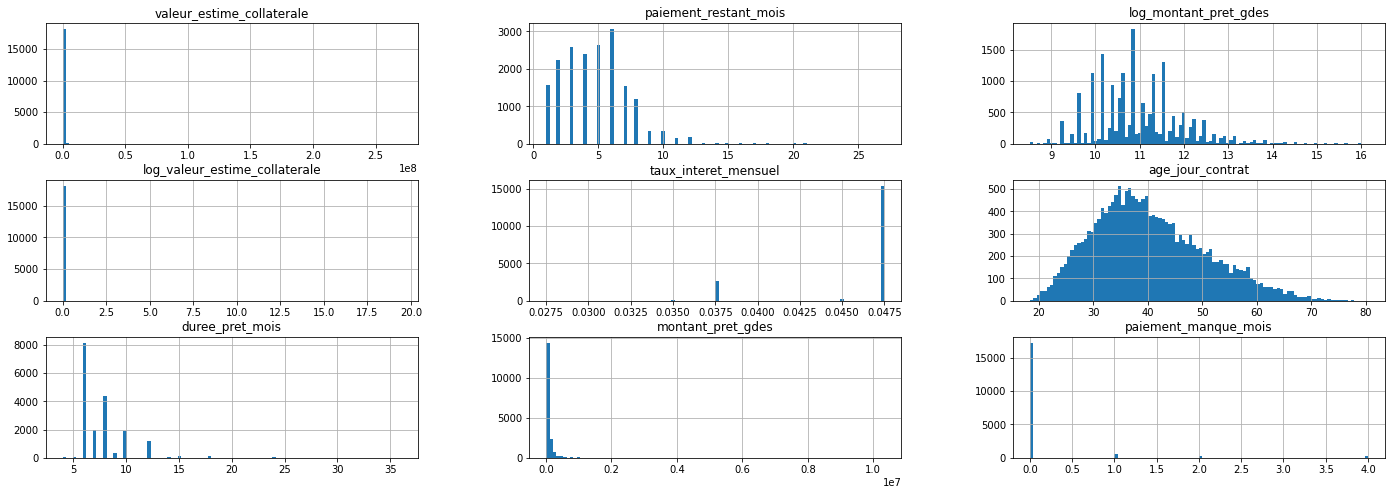

In [6]:
dfacme[list(nfs[nfs>0].index)+['paiement_manque_mois']].hist(bins=100, figsize=(24,8))

In [7]:
dfacme[list(nfs[nfs>0].index)+['paiement_manque_mois']].corr()

,valeur_estime_collaterale,paiement_restant_mois,log_montant_pret_gdes,log_valeur_estime_collaterale,taux_interet_mensuel,age_jour_contrat,duree_pret_mois,montant_pret_gdes,paiement_manque_mois
valeur_estime_collaterale,1.000000,0.077665,0.120126,0.357804,-0.088193,0.017596,0.135831,0.209693,-0.005211
paiement_restant_mois,0.077665,1.000000,0.372270,0.240894,-0.219288,0.025349,0.556494,0.299952,0.004517
log_montant_pret_gdes,0.120126,0.372270,1.000000,0.353013,-0.350089,0.131547,0.682159,0.560144,-0.009466
log_valeur_estime_collaterale,0.357804,0.240894,0.353013,1.000000,-0.272864,0.035676,0.376702,0.532195,-0.015888
taux_interet_mensuel,-0.088193,-0.219288,-0.350089,-0.272864,1.000000,-0.089734,-0.379800,-0.325972,0.036159
age_jour_contrat,0.017596,0.025349,0.131547,0.035676,-0.089734,1.000000,0.083968,0.067813,-0.053131
duree_pret_mois,0.135831,0.556494,0.682159,0.376702,-0.379800,0.083968,1.000000,0.532187,0.011270
montant_pret_gdes,0.209693,0.299952,0.560144,0.532195,-0.325972,0.067813,0.532187,1.000000,-0.005633
paiement_manque_mois,-0.005211,0.004517,-0.009466,-0.015888,0.036159,-0.053131,0.011270,-0.005633,1.000000


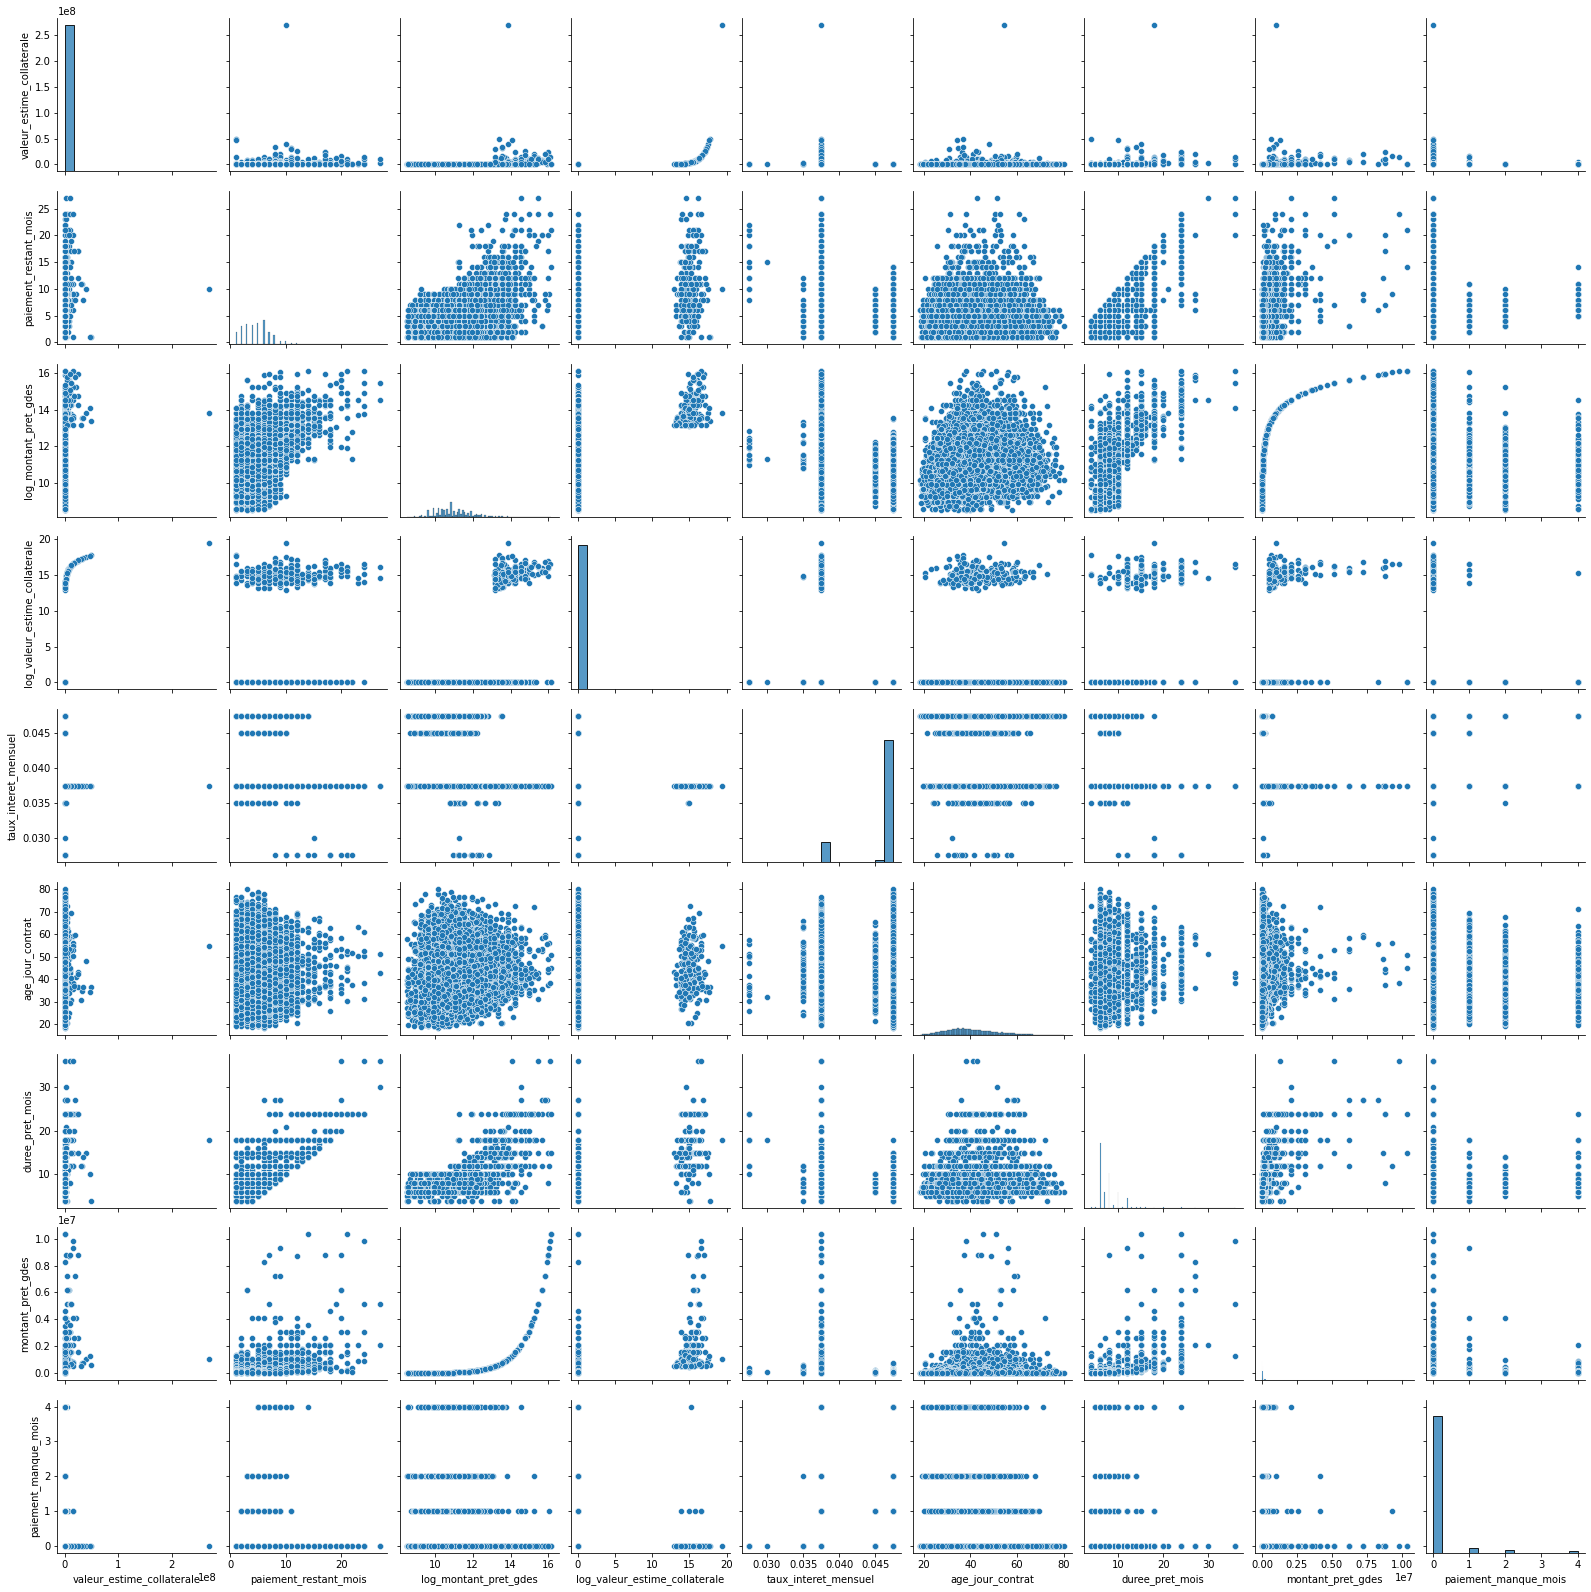

In [8]:
sns.pairplot(dfacme[list(nfs[nfs>0].index)+['paiement_manque_mois']])

In [9]:
cfs = dfacme[categorical_features].describe().loc['unique']
dfacme[categorical_features].describe()

,departement_naissance,ville_naissance,quartier_naissance,status_marital,genre,departement_activite,ville_activite,zone_activite,status_pret,secteur_pret,salarie,niveau_education,but_du_pret,collaterale_type
count,18366,18366,18366,18366,18366,18366,18366,18366,18366,18366,18366,18366,18366,18366
unique,10,134,1,6,2,7,66,1,5,3,1,4,10,2
top,Ouest,Port-au-Prince,N,Concubinage,F,Ouest,Saint Marc,N,COURANT,Commerce,N,Sec,Augmentation Stock,N
freq,4384,1286,18366,6354,11661,6769,1640,18366,15821,16524,18366,8709,16713,18129


In [10]:
categorical_anova_f = pd.Series(dict((_, sm.stats.anova_lm(ols(f"paiement_manque_mois ~ C({_})", data=dfacme).fit(), typ=1).loc[f"C({_})"]["F"]) for _ in cfs[cfs>1].index if _ != 'status_pret'))
categorical_anova_f.sort_values(ascending=False)

departement_activite     43.940329
departement_naissance    21.945977
ville_activite            9.255551
genre                     5.052748
collaterale_type          4.780646
ville_naissance           4.173394
but_du_pret               3.510467
secteur_pret              3.423649
niveau_education          2.244732
status_marital            2.151639
dtype: float64

In [11]:
for _ in cfs[(1 < cfs) & (cfs < 30)].index:
    if _ != 'status_pret':
        display(dfacme.groupby(_)[['paiement_manque_mois']].describe())

paiement_manque_mois                                     \
                                     count      mean       std  min  25%  50%   
departement_naissance                                                           
Artibonite                          3665.0  0.094679  0.469061  0.0  0.0  0.0   
Centre                              4062.0  0.042097  0.312192  0.0  0.0  0.0   
Grand-Anse                          1354.0  0.189808  0.716307  0.0  0.0  0.0   
Nippes                               726.0  0.089532  0.408834  0.0  0.0  0.0   
Nord                                 937.0  0.052295  0.349660  0.0  0.0  0.0   
Nord Est                              52.0  0.211538  0.824539  0.0  0.0  0.0   
Nord Ouest                           268.0  0.104478  0.428719  0.0  0.0  0.0   
Ouest                               4384.0  0.151460  0.591874  0.0  0.0  0.0   
Sud                                 2361.0  0.178738  0.682273  0.0  0.0  0.0   
Sud Est                              557.0  0.052065  0.298347  0.0  0.0  0.0   

                                 
                       75%  max  
departement_naissance            
Artibonite             0.0  4.0  
Centre                 0.0  4.0  
Grand-Anse             0.0  4.0  
Nippes                 0.0  4.0  
Nord                   0.0  4.0  
Nord Est               0.0  4.0  
Nord Ouest             0.0  4.0  
Ouest                  0.0  4.0  
Sud                    0.0  4.0  
Sud Est                0.0  4.0

paiement_manque_mois                                          \
                              count      mean       std  min  25%  50%  75%   
status_marital                                                                
Concubinage                  6354.0  0.117564  0.531279  0.0  0.0  0.0  0.0   
Célibataire                  2898.0  0.126294  0.554200  0.0  0.0  0.0  0.0   
Divorcé                        61.0  0.081967  0.378377  0.0  0.0  0.0  0.0   
Marié                        5797.0  0.100224  0.504084  0.0  0.0  0.0  0.0   
Séparé                       2314.0  0.117545  0.525209  0.0  0.0  0.0  0.0   
Veuf                          942.0  0.076433  0.394566  0.0  0.0  0.0  0.0   

                     
                max  
status_marital       
Concubinage     4.0  
Célibataire     4.0  
Divorcé         2.0  
Marié           4.0  
Séparé          4.0  
Veuf            4.0

paiement_manque_mois                                             
                     count      mean       std  min  25%  50%  75%  max
genre                                                                  
F                  11661.0  0.104708  0.496916  0.0  0.0  0.0  0.0  4.0
M                   6705.0  0.122595  0.555836  0.0  0.0  0.0  0.0  4.0

paiement_manque_mois                                     \
                                    count      mean       std  min  25%  50%   
departement_activite                                                           
Artibonite                         3527.0  0.091863  0.467381  0.0  0.0  0.0   
Centre                             4054.0  0.037494  0.298983  0.0  0.0  0.0   
Grand-Anse                          434.0  0.142857  0.613819  0.0  0.0  0.0   
Nippes                              781.0  0.070423  0.330359  0.0  0.0  0.0   
Nord                                681.0  0.030837  0.282719  0.0  0.0  0.0   
Ouest                              6769.0  0.135027  0.547748  0.0  0.0  0.0   
Sud                                2120.0  0.242925  0.817429  0.0  0.0  0.0   

                                
                      75%  max  
departement_activite            
Artibonite            0.0  4.0  
Centre                0.0  4.0  
Grand-Anse            0.0  4.0  
Nippes                0.0  4.0  
Nord                  0.0  4.0  
Ouest                 0.0  4.0  
Sud                   0.0  4.0

paiement_manque_mois                                             
                            count      mean       std  min  25%  50%  75%  max
secteur_pret                                                                  
Commerce                  16524.0  0.114440  0.529159  0.0  0.0  0.0  0.0  4.0
Production                 1661.0  0.079470  0.416172  0.0  0.0  0.0  0.0  4.0
Service                     181.0  0.110497  0.445908  0.0  0.0  0.0  0.0  4.0

paiement_manque_mois                                          \
                                count      mean       std  min  25%  50%  75%   
niveau_education                                                                
AUCUN                          1298.0  0.079353  0.444990  0.0  0.0  0.0  0.0   
Prim                           6597.0  0.117174  0.530230  0.0  0.0  0.0  0.0   
Sec                            8709.0  0.109197  0.512494  0.0  0.0  0.0  0.0   
Univ                           1762.0  0.122588  0.559630  0.0  0.0  0.0  0.0   

                       
                  max  
niveau_education       
AUCUN             4.0  
Prim              4.0  
Sec               4.0  
Univ              4.0

paiement_manque_mois                                \
                                        count      mean       std  min  25%   
but_du_pret                                                                   
Acquisition Matériel                     46.0  0.086957  0.284885  0.0  0.0   
Assortiment Marchandises                180.0  0.038889  0.323457  0.0  0.0   
Augmentation Stock                    16713.0  0.117693  0.534782  0.0  0.0   
Autres                                   43.0  0.116279  0.625235  0.0  0.0   
Consommation                              3.0  0.000000  0.000000  0.0  0.0   
Diversication Stock                      29.0  0.137931  0.350931  0.0  0.0   
Investissement                            4.0  0.000000  0.000000  0.0  0.0   
Matiere Premiere                        702.0  0.052707  0.364333  0.0  0.0   
Rantre Lekol                            313.0  0.031949  0.224183  0.0  0.0   
Rentrée Scolaire                        333.0  0.027027  0.196020  0.0  0.0   

                                         
                          50%  75%  max  
but_du_pret                              
Acquisition Matériel      0.0  0.0  1.0  
Assortiment Marchandises  0.0  0.0  4.0  
Augmentation Stock        0.0  0.0  4.0  
Autres                    0.0  0.0  4.0  
Consommation              0.0  0.0  0.0  
Diversication Stock       0.0  0.0  1.0  
Investissement            0.0  0.0  0.0  
Matiere Premiere          0.0  0.0  4.0  
Rantre Lekol              0.0  0.0  2.0  
Rentrée Scolaire          0.0  0.0  2.0

paiement_manque_mois                                          \
                                count      mean       std  min  25%  50%  75%   
collaterale_type                                                                
Hyphoteque                      237.0  0.037975  0.295863  0.0  0.0  0.0  0.0   
N                             18129.0  0.112196  0.521482  0.0  0.0  0.0  0.0   

                       
                  max  
collaterale_type       
Hyphoteque        4.0  
N                 4.0

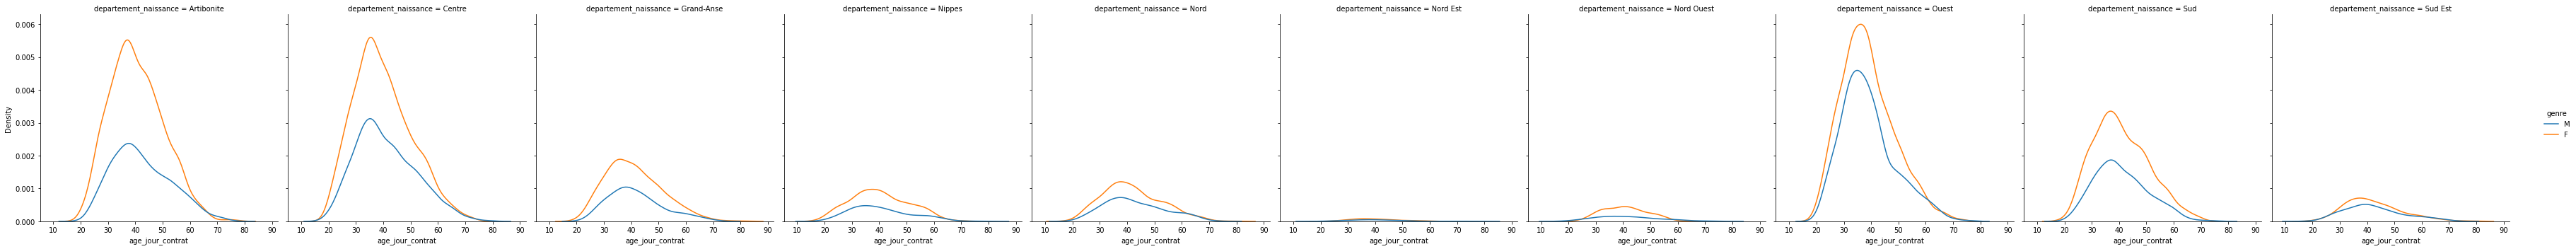

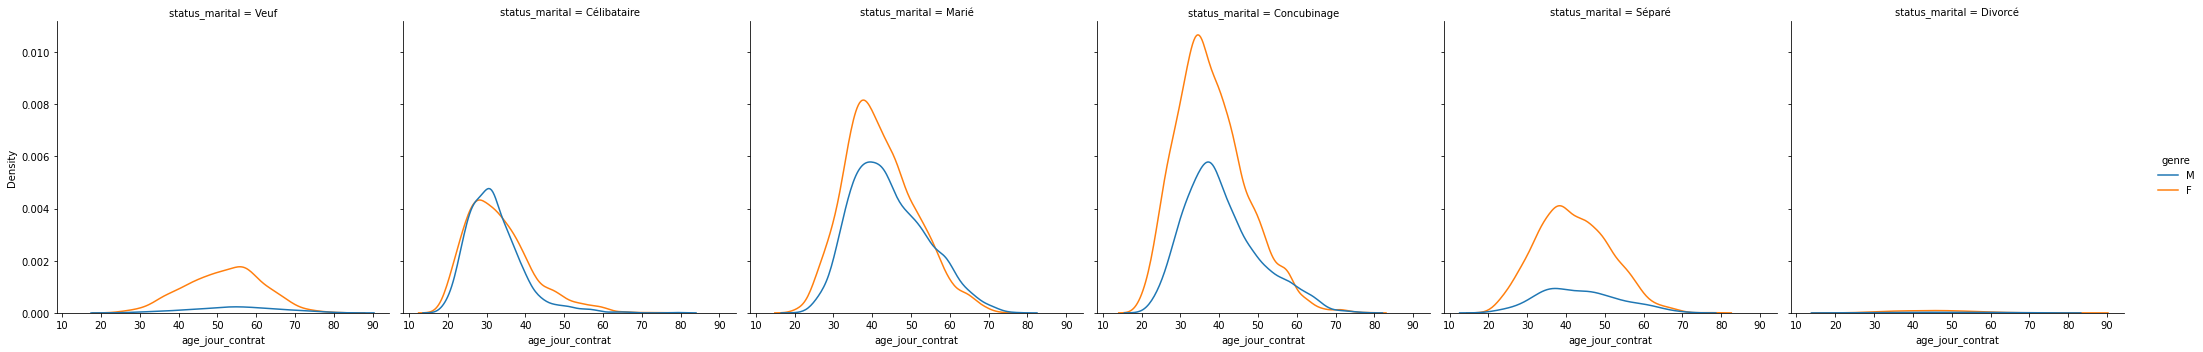

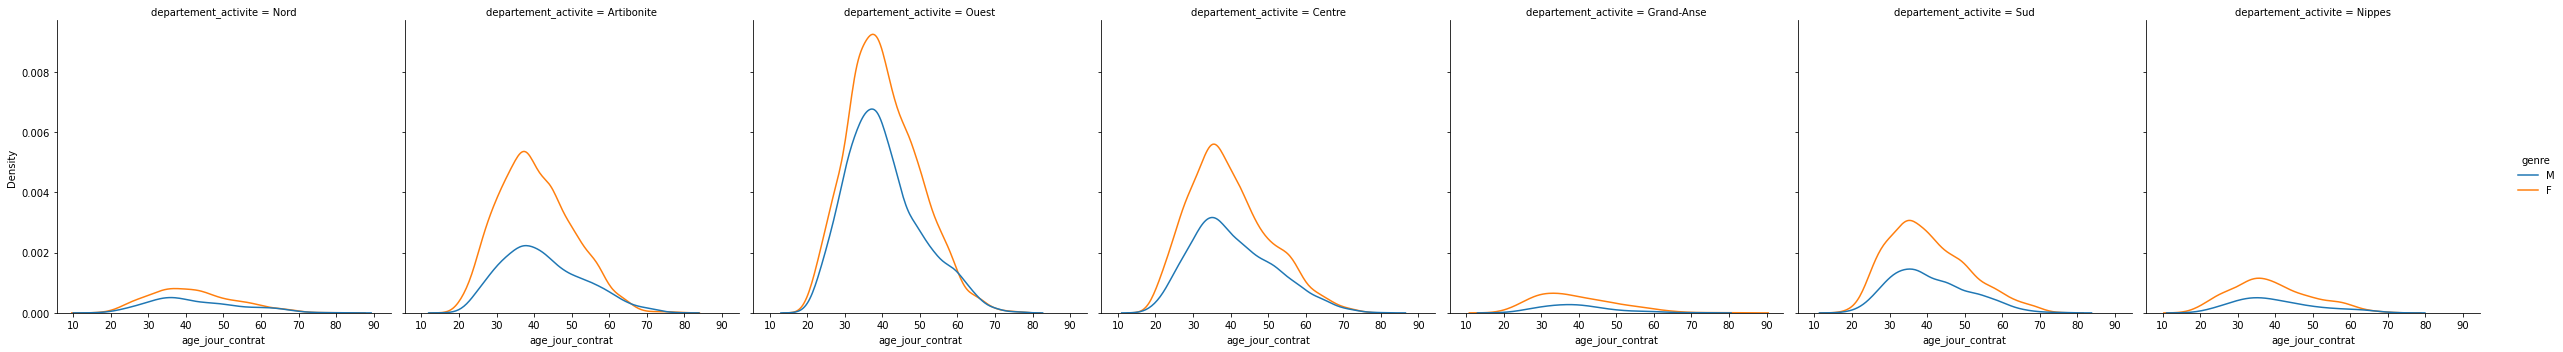

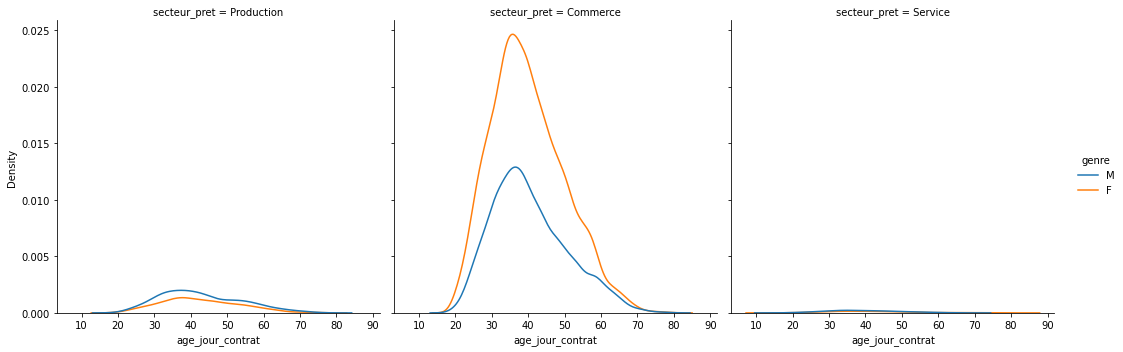

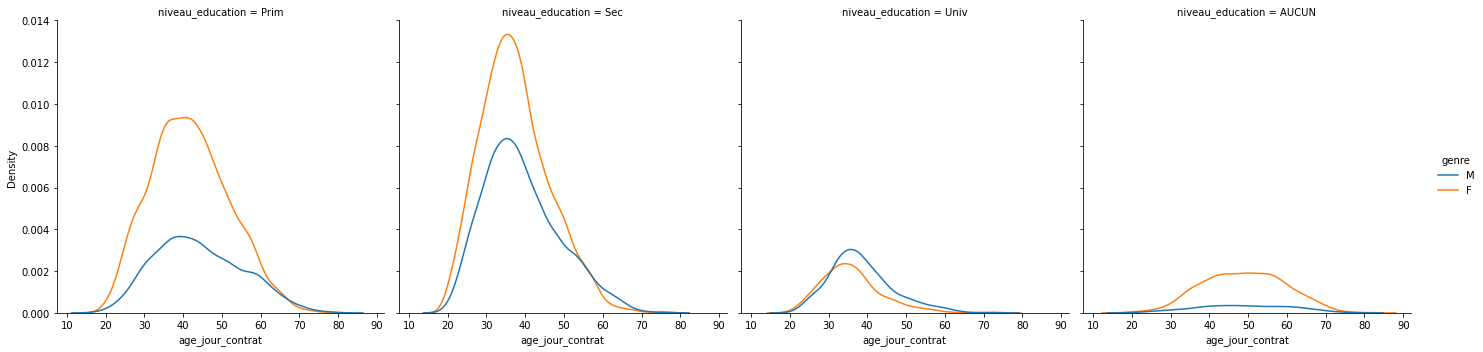

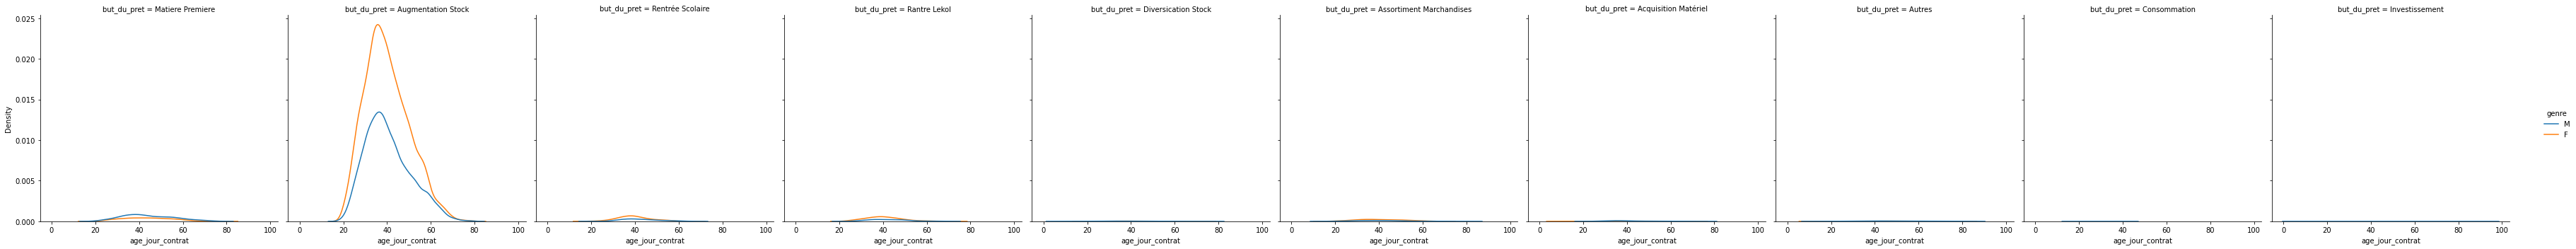

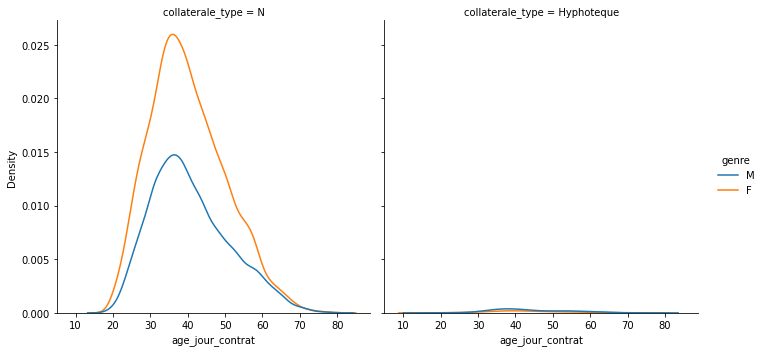

In [12]:
for _ in cfs[(1 < cfs) & (cfs < 30)].index:
    if _ not in {'status_pret', 'genre'}:
        sns.displot(dfacme, x="age_jour_contrat", col=_, hue="genre", kind="kde", warn_singular=False)